In [1]:
import pandas as pd
import numpy as np
# from dotenv import load_dotenv
from pandas.tseries.offsets import DateOffset
import os
import requests
import datetime
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt
from numpy.lib import math
from tensorflow.keras.layers import Dropout
from pathlib import Path
import yfinance as yf

%matplotlib inline

## Data Retreival/Formatting

In [2]:
# Pull data

btc_df = yf.download('BTC-USD', start='2020-12-01')[['Open','High','Low','Volume','Close']]
btc_df.index.name = 'timestamp'

btc_df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Volume,Close
timestamp,,,,,
2020-12-01 00:00:00+00:00,19633.769531,19845.974609,18321.921875,49633658712,18802.998047
2020-12-02 00:00:00+00:00,18801.744141,19308.330078,18347.718750,37387697139,19201.091797
2020-12-03 00:00:00+00:00,19205.925781,19566.191406,18925.785156,31930317405,19445.398438
2020-12-04 00:00:00+00:00,19446.966797,19511.404297,18697.193359,33872388058,18699.765625
2020-12-05 00:00:00+00:00,18698.384766,19160.449219,18590.193359,27242455064,19154.230469
...,...,...,...,...,...
2022-10-06 00:00:00+00:00,20161.039062,20408.392578,19900.087891,34711412966,19955.443359
2022-10-07 00:00:00+00:00,19957.558594,20041.085938,19395.792969,29227315390,19546.849609
2022-10-08 00:00:00+00:00,19546.328125,19601.695312,19299.414062,16437423167,19416.568359


In [3]:
# use GET method and connect to API endpoint (Fear and Greed Index API)
r = requests.get('https://api.alternative.me/fng/?limit=0')

In [4]:
# Create fear and greed dataframe

fear_and_greed = pd.DataFrame(r.json()['data'])

fear_and_greed

,value,value_classification,timestamp,time_until_update
0,22,Extreme Fear,1665360000,70746
1,22,Extreme Fear,1665273600,NaN
2,24,Extreme Fear,1665187200,NaN
3,23,Extreme Fear,1665100800,NaN
4,26,Fear,1665014400,NaN
...,...,...,...,...
1705,11,Extreme Fear,1517788800,NaN
1706,24,Extreme Fear,1517702400,NaN
1707,40,Fear,1517616000,NaN
1708,15,Extreme Fear,1517529600,NaN


In [5]:
# convert the value to an integer instead of an object
fear_and_greed['value'] = fear_and_greed.value.astype(int)

# convert timestamp to usable format
fear_and_greed['timestamp'] = pd.to_datetime(fear_and_greed['timestamp'], unit='s', utc=True)

In [6]:
# set index to timsetamp
fear_and_greed = fear_and_greed.set_index('timestamp')

In [7]:
# reorganize data to oldest data points first
fear_and_greed = fear_and_greed[::-1]

fear_and_greed 

,value,value_classification,time_until_update
timestamp,,,
2018-02-01 00:00:00+00:00,30,Fear,NaN
2018-02-02 00:00:00+00:00,15,Extreme Fear,NaN
2018-02-03 00:00:00+00:00,40,Fear,NaN
2018-02-04 00:00:00+00:00,24,Extreme Fear,NaN
2018-02-05 00:00:00+00:00,11,Extreme Fear,NaN
...,...,...,...
2022-10-06 00:00:00+00:00,26,Fear,NaN
2022-10-07 00:00:00+00:00,23,Extreme Fear,NaN
2022-10-08 00:00:00+00:00,24,Extreme Fear,NaN


In [8]:
# Merge btc_df and fear_and_greed
signals_df = fear_and_greed.merge(btc_df, on ='timestamp')

# Drop 'time_until_update' column
signals_df = signals_df.drop(columns='time_until_update')

signals_df

,value,value_classification,Open,High,Low,Volume,Close
timestamp,,,,,,,
2020-12-01 00:00:00+00:00,95,Extreme Greed,19633.769531,19845.974609,18321.921875,49633658712,18802.998047
2020-12-02 00:00:00+00:00,92,Extreme Greed,18801.744141,19308.330078,18347.718750,37387697139,19201.091797
2020-12-03 00:00:00+00:00,92,Extreme Greed,19205.925781,19566.191406,18925.785156,31930317405,19445.398438
2020-12-04 00:00:00+00:00,92,Extreme Greed,19446.966797,19511.404297,18697.193359,33872388058,18699.765625
2020-12-05 00:00:00+00:00,93,Extreme Greed,18698.384766,19160.449219,18590.193359,27242455064,19154.230469
...,...,...,...,...,...,...,...
2022-10-06 00:00:00+00:00,26,Fear,20161.039062,20408.392578,19900.087891,34711412966,19955.443359
2022-10-07 00:00:00+00:00,23,Extreme Fear,19957.558594,20041.085938,19395.792969,29227315390,19546.849609
2022-10-08 00:00:00+00:00,24,Extreme Fear,19546.328125,19601.695312,19299.414062,16437423167,19416.568359


In [9]:
categorical_variables = ['value_classification']

In [10]:
# Encode value_classification column

enc=OneHotEncoder(sparse=False)
encoded_data=enc.fit_transform(signals_df[categorical_variables])

In [11]:
# Create encoded dataframe

encoded_df = pd.DataFrame(
    encoded_data,
    columns = enc.get_feature_names(categorical_variables)
)

encoded_df

c:\Users\gtkhh\anaconda3\envs\dev\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,value_classification_Extreme Fear,value_classification_Extreme Greed,value_classification_Fear,value_classification_Greed,value_classification_Neutral
0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...
674,0.0,0.0,1.0,0.0,0.0
675,1.0,0.0,0.0,0.0,0.0
676,1.0,0.0,0.0,0.0,0.0
677,1.0,0.0,0.0,0.0,0.0


In [12]:
# Prep for combining dataframes

signals_df = signals_df.drop(columns='value_classification')

signals_df = signals_df.reset_index()

In [13]:
# Combine the DataFrames that contain the encoded categorical data and the numerical data
combined_df = pd.concat(
    [
        signals_df,
        encoded_df
    ],
    axis=1
)

combined_df = combined_df.set_index('timestamp')

# Reveiw the DataFrame
combined_df

,value,Open,High,Low,Volume,Close,value_classification_Extreme Fear,value_classification_Extreme Greed,value_classification_Fear,value_classification_Greed,value_classification_Neutral
timestamp,,,,,,,,,,,
2020-12-01 00:00:00+00:00,95,19633.769531,19845.974609,18321.921875,49633658712,18802.998047,0.0,1.0,0.0,0.0,0.0
2020-12-02 00:00:00+00:00,92,18801.744141,19308.330078,18347.718750,37387697139,19201.091797,0.0,1.0,0.0,0.0,0.0
2020-12-03 00:00:00+00:00,92,19205.925781,19566.191406,18925.785156,31930317405,19445.398438,0.0,1.0,0.0,0.0,0.0
2020-12-04 00:00:00+00:00,92,19446.966797,19511.404297,18697.193359,33872388058,18699.765625,0.0,1.0,0.0,0.0,0.0
2020-12-05 00:00:00+00:00,93,18698.384766,19160.449219,18590.193359,27242455064,19154.230469,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-10-06 00:00:00+00:00,26,20161.039062,20408.392578,19900.087891,34711412966,19955.443359,0.0,0.0,1.0,0.0,0.0
2022-10-07 00:00:00+00:00,23,19957.558594,20041.085938,19395.792969,29227315390,19546.849609,1.0,0.0,0.0,0.0,0.0
2022-10-08 00:00:00+00:00,24,19546.328125,19601.695312,19299.414062,16437423167,19416.568359,1.0,0.0,0.0,0.0,0.0


In [14]:
# Use the pct_change function to generate  returns from close prices
combined_df["Actual Returns"] = combined_df["Close"].pct_change()

# Drop na
combined_df=combined_df.dropna()

combined_df

,value,Open,High,Low,Volume,Close,value_classification_Extreme Fear,value_classification_Extreme Greed,value_classification_Fear,value_classification_Greed,value_classification_Neutral,Actual Returns
timestamp,,,,,,,,,,,,
2020-12-02 00:00:00+00:00,92,18801.744141,19308.330078,18347.718750,37387697139,19201.091797,0.0,1.0,0.0,0.0,0.0,0.021172
2020-12-03 00:00:00+00:00,92,19205.925781,19566.191406,18925.785156,31930317405,19445.398438,0.0,1.0,0.0,0.0,0.0,0.012724
2020-12-04 00:00:00+00:00,92,19446.966797,19511.404297,18697.193359,33872388058,18699.765625,0.0,1.0,0.0,0.0,0.0,-0.038345
2020-12-05 00:00:00+00:00,93,18698.384766,19160.449219,18590.193359,27242455064,19154.230469,0.0,1.0,0.0,0.0,0.0,0.024303
2020-12-06 00:00:00+00:00,95,19154.179688,19390.500000,18897.894531,25293775714,19345.121094,0.0,1.0,0.0,0.0,0.0,0.009966
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-06 00:00:00+00:00,26,20161.039062,20408.392578,19900.087891,34711412966,19955.443359,0.0,0.0,1.0,0.0,0.0,-0.010182
2022-10-07 00:00:00+00:00,23,19957.558594,20041.085938,19395.792969,29227315390,19546.849609,1.0,0.0,0.0,0.0,0.0,-0.020475
2022-10-08 00:00:00+00:00,24,19546.328125,19601.695312,19299.414062,16437423167,19416.568359,1.0,0.0,0.0,0.0,0.0,-0.006665


In [15]:
# # Initialize the new Signal column
# combined_df['Signal'] = 0.0

# # When Actual Returns are greater than or equal to 0, generate signal to buy stock long
# combined_df.loc[(combined_df['Actual Returns'] >= 0), 'Signal'] = 1

# # When Actual Returns are less than 0, generate signal to sell stock short
# combined_df.loc[(combined_df['Actual Returns'] < 0), 'Signal'] = 0

# combined_df

In [16]:
# # Drop Actual Returns
# combined_df = combined_df.drop(columns=['Actual Returns'])

#Rename value column to fear_and_greed
combined_df = combined_df.rename(columns = {'value':'fear_and_greed'})

display(combined_df.shape)
display(combined_df.head())

(678, 12)

,fear_and_greed,Open,High,Low,Volume,Close,value_classification_Extreme Fear,value_classification_Extreme Greed,value_classification_Fear,value_classification_Greed,value_classification_Neutral,Actual Returns
timestamp,,,,,,,,,,,,
2020-12-02 00:00:00+00:00,92,18801.744141,19308.330078,18347.718750,37387697139,19201.091797,0.0,1.0,0.0,0.0,0.0,0.021172
2020-12-03 00:00:00+00:00,92,19205.925781,19566.191406,18925.785156,31930317405,19445.398438,0.0,1.0,0.0,0.0,0.0,0.012724
2020-12-04 00:00:00+00:00,92,19446.966797,19511.404297,18697.193359,33872388058,18699.765625,0.0,1.0,0.0,0.0,0.0,-0.038345
2020-12-05 00:00:00+00:00,93,18698.384766,19160.449219,18590.193359,27242455064,19154.230469,0.0,1.0,0.0,0.0,0.0,0.024303
2020-12-06 00:00:00+00:00,95,19154.179688,19390.500000,18897.894531,25293775714,19345.121094,0.0,1.0,0.0,0.0,0.0,0.009966


#### The following code block is necessary for traditional ML, I believe with tensors it may be unnecessary

In [17]:
# # Shift X data to predict the future Y signal value
# combined_df[['fear_and_greed','Open', 'High','Low','Volume','Close','value_classification_Extreme Fear','value_classification_Extreme Greed','value_classification_Fear','value_classification_Greed','value_classification_Neutral']]=combined_df[['fear_and_greed','Open','High','Low','Volume','Close','value_classification_Extreme Fear','value_classification_Extreme Greed','value_classification_Fear','value_classification_Greed','value_classification_Neutral']].shift()
# display(combined_df.head())

# # Drop rows w/ empty values
# combined_df = combined_df.dropna()
# display(combined_df.head())

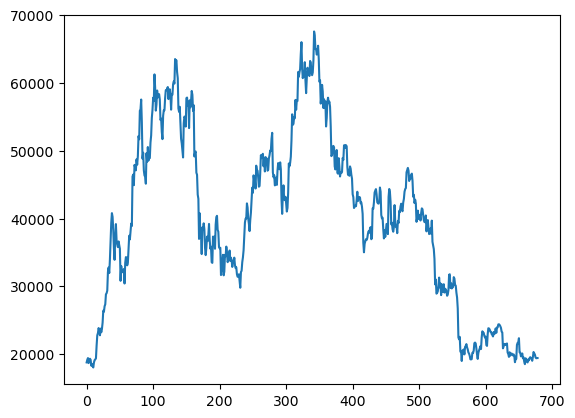

In [18]:
plt.plot(range(len(signals_df)), signals_df[['Close']])

### Splitting data into 3D Tensors

In [19]:
# Split test and train data

split_ratio=.7
train_count=int(len(combined_df)*.7)

train=combined_df.iloc[:train_count]
test=combined_df.iloc[train_count:]

display(train.head())

,fear_and_greed,Open,High,Low,Volume,Close,value_classification_Extreme Fear,value_classification_Extreme Greed,value_classification_Fear,value_classification_Greed,value_classification_Neutral,Actual Returns
timestamp,,,,,,,,,,,,
2020-12-02 00:00:00+00:00,92,18801.744141,19308.330078,18347.718750,37387697139,19201.091797,0.0,1.0,0.0,0.0,0.0,0.021172
2020-12-03 00:00:00+00:00,92,19205.925781,19566.191406,18925.785156,31930317405,19445.398438,0.0,1.0,0.0,0.0,0.0,0.012724
2020-12-04 00:00:00+00:00,92,19446.966797,19511.404297,18697.193359,33872388058,18699.765625,0.0,1.0,0.0,0.0,0.0,-0.038345
2020-12-05 00:00:00+00:00,93,18698.384766,19160.449219,18590.193359,27242455064,19154.230469,0.0,1.0,0.0,0.0,0.0,0.024303
2020-12-06 00:00:00+00:00,95,19154.179688,19390.500000,18897.894531,25293775714,19345.121094,0.0,1.0,0.0,0.0,0.0,0.009966


In [20]:
# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Fit the scaler to the features training dataset
train_scaled = scaler.fit_transform(train)

train_scaled

array([[0.96470588, 0.01516056, 0.02058299, ..., 0.        , 0.        ,
        0.48852773],
       [0.96470588, 0.02332611, 0.02568702, ..., 0.        , 0.        ,
        0.46254321],
       [0.96470588, 0.02819578, 0.02460258, ..., 0.        , 0.        ,
        0.30547015],
       ...,
       [0.17647059, 0.46251016, 0.47360922, ..., 0.        , 0.        ,
        0.48723304],
       [0.21176471, 0.47967856, 0.47600047, ..., 0.        , 0.        ,
        0.45206804],
       [0.24705882, 0.48769413, 0.47450821, ..., 0.        , 0.        ,
        0.354676  ]])

In [21]:
# Scale test data
test_scaled = scaler.fit_transform(test)

test_scaled

array([[0.44444444, 0.78525993, 0.77091731, ..., 0.        , 0.        ,
        0.58536315],
       [0.37037037, 0.779312  , 0.82860904, ..., 0.        , 0.        ,
        0.71812499],
       [0.46296296, 0.8239238 , 0.82062346, ..., 0.        , 0.        ,
        0.64827889],
       ...,
       [0.33333333, 0.03497922, 0.01612881, ..., 0.        , 0.        ,
        0.57578018],
       [0.2962963 , 0.03052419, 0.01408556, ..., 0.        , 0.        ,
        0.60663298],
       [0.2962963 , 0.03121347, 0.01304552, ..., 0.        , 0.        ,
        0.60151897]])

In [22]:
# Set global candles variable
candles=14

# Create X training set
X_train = []

for i in range(len(train_scaled) - candles):
    X_train.append(train_scaled[:,:10][i:i+candles])

X_train = np.array(X_train)
X_train.shape

(460, 14, 10)

In [23]:
# Create y training set
y_train = []

for i in range(len(train_scaled) - candles):
    y_train.append(train_scaled[:,11][i+candles])

y_train = np.array(y_train)
display(y_train.shape)
display(y_train[:5])


(460,)

array([0.72334915, 0.63911745, 0.46829346, 0.52069658, 0.3728288 ])

In [24]:
# Create X test set
X_test = []

for i in range(len(test_scaled) - candles):
    X_test.append(test_scaled[:,:10][i  : i+candles])

X_test = np.array(X_test)
X_test.shape

(190, 14, 10)

In [25]:
# Create y test set
y_test = []

for i in range(len(test_scaled) - candles):
    y_test.append(test_scaled[:,11][i+candles])

y_test = np.array(y_test)
y_test.shape

(190,)

## Model Creation

In [26]:
# Check if GPU is working

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [27]:
# Create the Sequential model instance
class_nn = Sequential()

# Define the number of neurons in the output layer
number_output_neurons = 1

#Define the number of hidden nodes for the first hidden layer
hidden_nodes_layer1 = 64

# Define hidden nodes for all hidden layers
hidden_nodes = 256
display(hidden_nodes)

# Review the number hidden nodes in the first layer
display(hidden_nodes_layer1)

#Define the number of hidden nodes for the second hidden layer
hidden_nodes_layer2 = 64

# Review the number hidden nodes in the second layer
display(hidden_nodes_layer2)

kernelSize=1

256

64

64

In [28]:
# Add first cnn layer
class_nn.add(Conv1D(filters=32, kernel_size=kernelSize, padding='same', activation='relu', input_shape=(candles,(len(combined_df.columns)-2))))

In [29]:
#Add second cnn layer
class_nn.add(Conv1D(filters=64, kernel_size=kernelSize, padding='same'))

In [30]:
# Add the first hidden layer
class_nn.add(LSTM(units=hidden_nodes, return_sequences=True,))

In [31]:
# Add dropout layer
class_nn.add(Dropout(rate=0.2))

In [32]:
# Add the second hidden layer
class_nn.add(LSTM(units=hidden_nodes, return_sequences=True))


In [33]:
# Add dropout layer
class_nn.add(Dropout(rate=0.2))

In [34]:
# # Add the third hidden layer
# class_nn.add(LSTM(units=hidden_nodes, return_sequences=True))

In [35]:
# # Add dropout layer
# class_nn.add(Dropout(rate=0.2))

In [36]:
# Add the fourth hidden layer
class_nn.add(LSTM(units=hidden_nodes, return_sequences=False))

In [37]:
# Add dropout layer
class_nn.add(Dropout(rate=0.2))

In [38]:
# Add Dense layer
# class_nn.add(Dense(units=6, activation='relu'))

In [39]:
# Add the output layer to the model specifying the number of output neurons and activation function
class_nn.add(Dense(units=1,  activation='linear'))


In [40]:
# Display the Sequential model summary, subclassed model requires build
class_nn.build(X_train.shape)
class_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 14, 32)            352       
                                                                 
 conv1d_1 (Conv1D)           (None, 14, 64)            2112      
                                                                 
 lstm (LSTM)                 (None, 14, 256)           328704    
                                                                 
 dropout (Dropout)           (None, 14, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 14, 256)           525312    
                                                                 
 dropout_1 (Dropout)         (None, 14, 256)           0         
                                                                 
 lstm_2 (LSTM)               (None, 256)               5

In [41]:
# Compile the Sequential model
# class_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=('accuracy','Precision', 'Recall'))

class_nn.compile(loss='mean_squared_error', optimizer='adam')

In [42]:
# Fit the model using epochs and the training data
class_model = class_nn.fit(X_train, y_train, epochs=20, validation_split=0.1)

Epoch 1/20
13/13 [==============================] - 30s 304ms/step - loss: 0.0590 - val_loss: 0.0239
Epoch 2/20
13/13 [==============================] - 0s 26ms/step - loss: 0.0210 - val_loss: 0.0166
Epoch 3/20
13/13 [==============================] - 0s 24ms/step - loss: 0.0172 - val_loss: 0.0184
Epoch 4/20
13/13 [==============================] - 2s 201ms/step - loss: 0.0167 - val_loss: 0.0172
Epoch 5/20
13/13 [==============================] - 0s 38ms/step - loss: 0.0163 - val_loss: 0.0169
Epoch 6/20
13/13 [==============================] - 3s 211ms/step - loss: 0.0174 - val_loss: 0.0164
Epoch 7/20
13/13 [==============================] - 0s 30ms/step - loss: 0.0162 - val_loss: 0.0165
Epoch 8/20
13/13 [==============================] - 0s 31ms/step - loss: 0.0172 - val_loss: 0.0167
Epoch 9/20
13/13 [==============================] - 2s 190ms/step - loss: 0.0175 - val_loss: 0.0168
Epoch 10/20
13/13 [==============================] - 0s 36ms/step - loss: 0.0167 - val_loss: 0.0164
Epoc

In [43]:
# # Evaluate the model loss and accuracy metrics using the evaluate method and the test data
# # model_loss, model_accuracy, model_precision, model_recall = class_nn.evaluate(X_test, y_test)

# model_loss, model_accuracy = class_nn.evaluate(X_test, y_test)

# # Display the model loss and accuracy results
# # print(f"Loss: {model_loss}, Accuracy: {model_accuracy}, Precision: {model_precision}, Recall: {model_recall}")

# print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

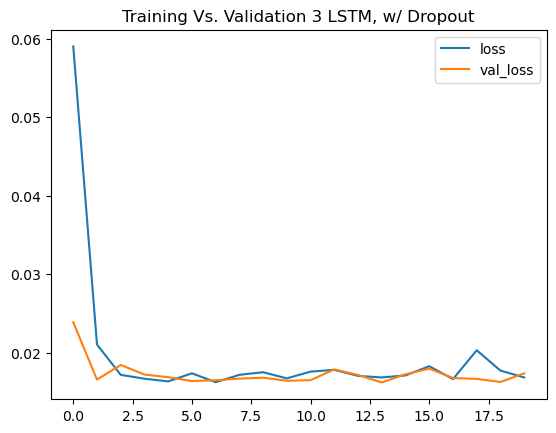

In [44]:
# Train vs test for loss
plt.plot(class_model.history["loss"])

plt.plot(class_model.history["val_loss"])

plt.title("Training Vs. Validation 3 LSTM, w/ Dropout")
plt.legend(["loss", "val_loss"])
plt.show()

In [45]:
# Make model predictionis

y_pred=class_nn.predict(X_test)

y_pred

6/6 [==============================] - 3s 13ms/step


array([[0.43542042],
       [0.43106252],
       [0.42668033],
       [0.42222455],
       [0.41578114],
       [0.41253787],
       [0.40887952],
       [0.40651974],
       [0.40610304],
       [0.40813202],
       [0.41134307],
       [0.41191414],
       [0.41295424],
       [0.41260782],
       [0.41160455],
       [0.4112965 ],
       [0.41029087],
       [0.4091789 ],
       [0.40536746],
       [0.40170413],
       [0.40096   ],
       [0.40171218],
       [0.4024352 ],
       [0.40635368],
       [0.40920192],
       [0.40755394],
       [0.40970814],
       [0.4074175 ],
       [0.40459043],
       [0.4040529 ],
       [0.39844388],
       [0.39381298],
       [0.389043  ],
       [0.38608402],
       [0.38913408],
       [0.39271578],
       [0.39627832],
       [0.3940899 ],
       [0.39656347],
       [0.39822507],
       [0.3993132 ],
       [0.40004233],
       [0.4003492 ],
       [0.39596874],
       [0.39171422],
       [0.3924387 ],
       [0.38729823],
       [0.387

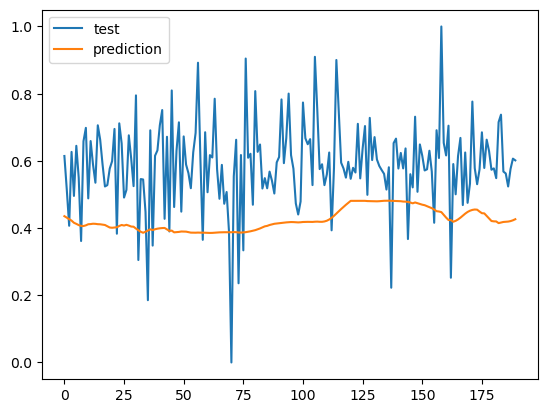

In [46]:
# Plot prediction results
plt.plot(range(len(y_test)), (y_test))
plt.plot(range(len(y_test)), (y_pred))
plt.legend(["test", "prediction"])

In [47]:
# Set the file path for the first alternative model
file_path = Path('Models/class_class_nn.h5')

# Export your model to a HDF5 file
class_nn.save(file_path)